In [1]:
import pandas as pd
import re
import numpy as np
import os


In [2]:
data_const=[]
with open ('disc/Emil Constantinescu_texts.txt', "r",encoding='utf-8') as myfile:
    data_const.append(myfile.readlines())

In [3]:
data_iliescu=[]
with open ('disc/Ion Iliescu_texts.txt', "r",encoding='utf-8') as myfile:
    data_iliescu.append(myfile.readlines())

In [4]:
data_basescu=[]
with open ('disc/Traian Basescu_texts.txt', "r",encoding='utf-8') as myfile:
    data_basescu.append(myfile.readlines())

In [5]:
data_iohannis=[]
with open ('disc/Klaus Iohannis_texts.txt', "r",encoding='utf-8') as myfile:
    data_iohannis.append(myfile.readlines())

In [6]:
df_const = pd.DataFrame(data_const).T
df_iohannis = pd.DataFrame(data_iohannis).T
df_basescu = pd.DataFrame(data_basescu).T
df_iliescu = pd.DataFrame(data_iliescu).T


In [7]:
df_const=df_const.assign(label='constantinescu')
df_iohannis=df_iohannis.assign(label='iohannis')
df_basescu=df_basescu.assign(label='basescu')
df_iliescu=df_iliescu.assign(label='iliescu')

In [8]:
df = pd.concat([df_const, df_iohannis, df_basescu,df_iliescu])

In [9]:
df.columns = ['text', 'labels']

In [10]:
def clean(df):

    df['text'].str.encode('utf-8', 'ignore').str.decode('utf-8')
    df['totalwords'] = df['text'].str.split().str.len()
    df = df[~(df['totalwords'] <= 4)]
    df = df[~(df['totalwords'] >= 500)]
    
    
    return df

In [11]:
df = clean(df)

In [12]:
def sts(df,illness):

    sum_tokens = df['totalwords'].sum()
    means_per_df = df['totalwords'].mean(axis=0)
    print('Mean per '+illness+ ' group '+' '+ str(means_per_df))
#     print('Mean per users from the '+ group_char + ' group '+str(mean_per_group))
    print(illness+' no.of tokens '+ str((sum_tokens)))

In [13]:
possible_labels = df.labels.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'constantinescu': 0, 'iohannis': 1, 'basescu': 2, 'iliescu': 3}

In [14]:
df['label'] = df.labels.replace(label_dict)
df=df.sample(frac=1)

In [15]:
df = df[['label','text']]

In [16]:
df.dropna(inplace=True)

In [17]:
from nltk.stem.snowball import RomanianStemmer
stemmer = RomanianStemmer()


In [18]:
def clean_text(df, col):
    from string import punctuation
    df = df.copy()
    
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

In [19]:
df_train_ = df[:10000]
df_test_ = df[10000:]

In [20]:
df_train_['text_clean'] = clean_text(df_train_, 'text')
df_test_['text_clean'] = clean_text(df_test_, 'text')

<ipython-input-20-c8ba2392ce93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_['text_clean'] = clean_text(df_train_, 'text')
<ipython-input-20-c8ba2392ce93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['text_clean'] = clean_text(df_test_, 'text')


In [21]:
train_arr=df_train_['text'].tolist()
test_arr=df_test_['text'].tolist()
train_lbl = df_train_['label'].tolist()
test_lbl = df_test_['label'].tolist()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [23]:
vectorizer = CountVectorizer()
vectorizer.fit(train_arr)
train_mat = vectorizer.transform(train_arr)
print (train_mat.shape)
test_mat = vectorizer.transform(test_arr)
print (test_mat.shape)

(10000, 44602)
(4073, 44602)


In [24]:
tfidf = TfidfTransformer()
tfidf.fit(train_mat)
train_tfmat = tfidf.transform(train_mat)
print (train_tfmat.shape)
test_tfmat = tfidf.transform(test_mat)
print (test_tfmat.shape)

(10000, 44602)
(4073, 44602)


In [25]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from pprint import pprint
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score
import numpy as np

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Bernoulli Naive Bayes

In [27]:
from sklearn.metrics import classification_report

In [28]:
bnb= BernoulliNB()
#fitting
bnb.fit(train_tfmat, train_lbl)
#ypred
ypredBnb = bnb.predict(test_tfmat)
print ('Bernoulli accuracy score')
print (accuracy_score(test_lbl, ypredBnb))

Bernoulli accuracy score
0.8941811932236681


In [29]:
print(classification_report(test_lbl, ypredBnb))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1375
           1       0.86      0.99      0.92      1990
           2       0.89      0.74      0.81       333
           3       0.86      0.86      0.86       375

    accuracy                           0.89      4073
   macro avg       0.90      0.85      0.87      4073
weighted avg       0.90      0.89      0.89      4073



[[1104  262    3    6]
 [   1 1966   22    1]
 [  17   24  248   44]
 [   6   39    6  324]]


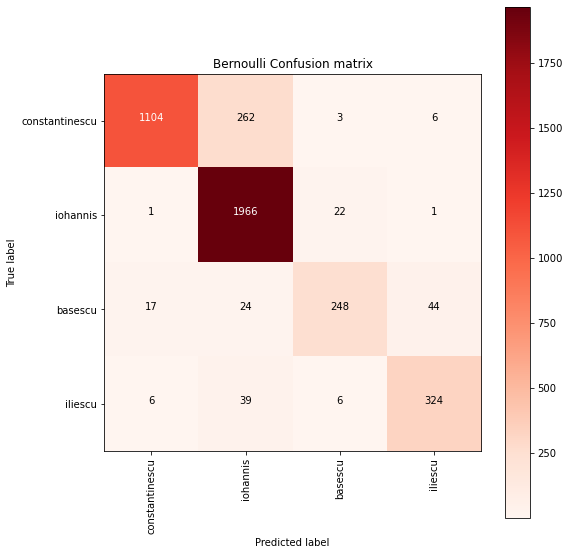

In [30]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredBnb), classes=label_dict,
                      title='Bernoulli Confusion matrix')

plt.show()

## Multinomial Naive Bayes

In [31]:
mnb=MultinomialNB()
#fitting
mnb.fit(train_tfmat, train_lbl)
ypredMnb = mnb.predict(test_tfmat)
print ('Multinomial accuracy score')
print (accuracy_score(test_lbl, ypredMnb))

Multinomial accuracy score
0.7456420328995826


In [32]:
print(classification_report(test_lbl, ypredMnb))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1375
           1       0.67      1.00      0.80      1990
           2       1.00      0.00      0.01       333
           3       0.00      0.00      0.00       375

    accuracy                           0.75      4073
   macro avg       0.65      0.44      0.41      4073
weighted avg       0.73      0.75      0.68      4073



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[1046  329    0    0]
 [   0 1990    0    0]
 [  45  287    1    0]
 [  22  353    0    0]]


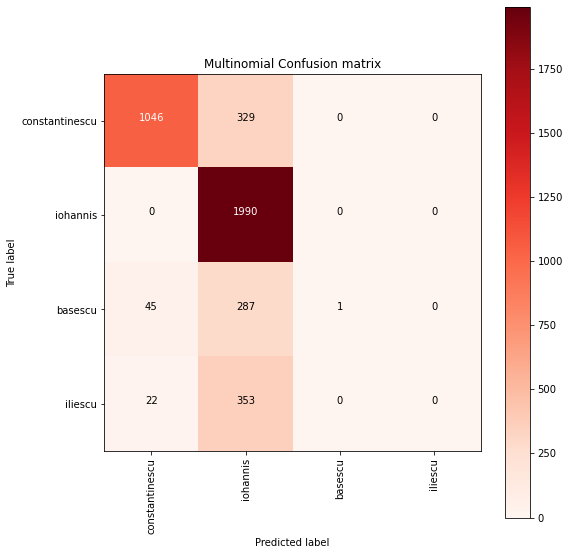

In [33]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredMnb), classes=label_dict,
                      title='Multinomial Confusion matrix')

plt.show()

## Linear Support Vector Classification

In [34]:
from sklearn.svm import LinearSVC, NuSVC, SVC

In [35]:
lsvm= LinearSVC()

#fitting
lsvm.fit(train_tfmat, train_lbl)

#ypred
ypredLsvm = lsvm.predict(test_tfmat)

In [36]:
print ('Linear Svm accuracy score')
print (accuracy_score(test_lbl, ypredLsvm))

Linear Svm accuracy score
0.95506997299288


In [37]:
print(classification_report(test_lbl, ypredLsvm))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1375
           1       0.96      0.97      0.97      1990
           2       0.97      0.88      0.93       333
           3       0.93      0.91      0.92       375

    accuracy                           0.96      4073
   macro avg       0.95      0.93      0.94      4073
weighted avg       0.96      0.96      0.95      4073



[[1315   51    1    8]
 [  45 1940    3    2]
 [  11   11  294   17]
 [  19   11    4  341]]


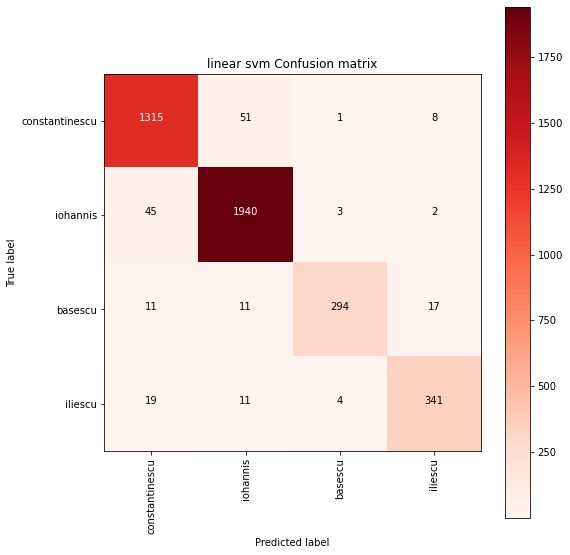

In [38]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredLsvm), classes=label_dict,
                      title='linear svm Confusion matrix')

plt.show()

## K-nearest neighbors WITH UNIFORM WEIGHT

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
knn_uni = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')
#fitting
knn_uni.fit(train_tfmat, train_lbl)
#ypred
ypred_knn_uni = knn_uni.predict(test_tfmat)
print ('Distant accuracy score')
print (accuracy_score(test_lbl, ypred_knn_uni))

Distant accuracy score
0.8185612570586791


In [41]:
print(classification_report(test_lbl, ypred_knn_uni))

              precision    recall  f1-score   support

           0       0.96      0.62      0.76      1375
           1       0.96      0.93      0.94      1990
           2       0.41      0.87      0.56       333
           3       0.63      0.91      0.74       375

    accuracy                           0.82      4073
   macro avg       0.74      0.83      0.75      4073
weighted avg       0.88      0.82      0.83      4073



[[ 859   65  322  129]
 [  26 1841   80   43]
 [   3    8  291   31]
 [   4    9   19  343]]


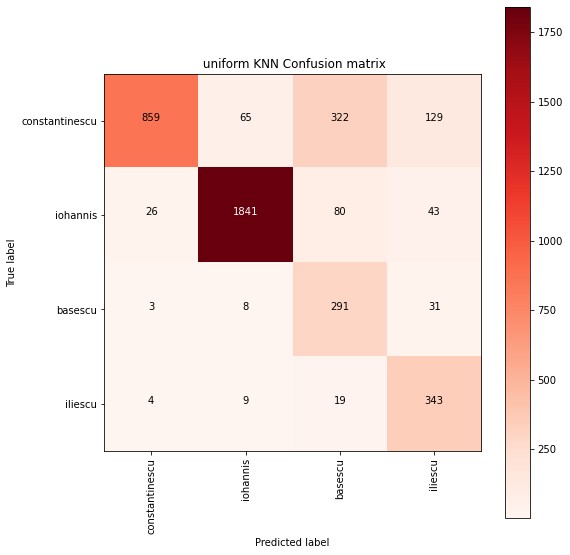

In [42]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypred_knn_uni), classes=label_dict,
                      title=' uniform KNN Confusion matrix')

plt.show()

## K-neighbors with distant neighbors

In [43]:
knn_dist = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
#fitting
knn_dist.fit(train_tfmat, train_lbl)
#ypred
ypred_knn_dist = knn_dist.predict(test_tfmat)
print ('Distant accuracy score')
print (accuracy_score(test_lbl, ypred_knn_dist))

Distant accuracy score
0.8183157377854161


In [44]:
print(classification_report(test_lbl, ypred_knn_dist))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76      1375
           1       0.96      0.92      0.94      1990
           2       0.42      0.89      0.57       333
           3       0.59      0.92      0.72       375

    accuracy                           0.82      4073
   macro avg       0.74      0.84      0.75      4073
weighted avg       0.89      0.82      0.83      4073



[[ 857   58  305  155]
 [  16 1837   83   54]
 [   2    6  295   30]
 [   1    9   21  344]]


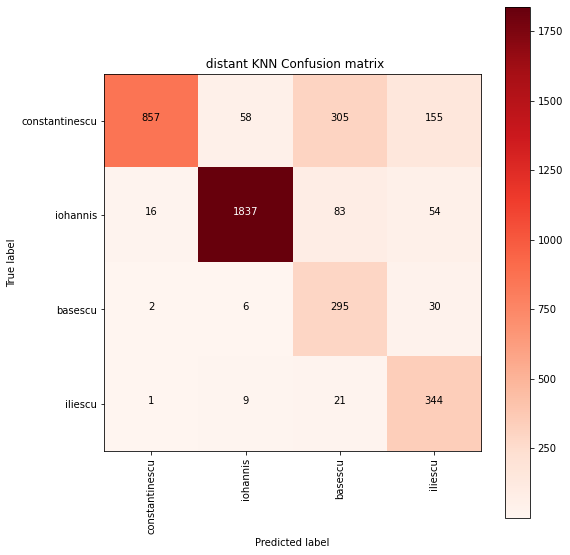

In [45]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypred_knn_dist), classes=label_dict,
                      title=' distant KNN Confusion matrix')

plt.show()